# Import modules

In [8]:
import qiskit
import pylatexenc
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
import gym
from functools import reduce
from collections import deque, defaultdict

In [10]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import math, random, time, itertools
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter, ParameterVector
from tqdm.notebook import tqdm
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp, CircuitOp, AerPauliExpectation
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit.utils import QuantumInstance, algorithm_globals

In [11]:
from Curling import Curling
from ansatz import build_circuit

# Build CIrucit

### Ansatz list
- 'base'
- 'hw_eff'
- 'universal'
- 'universal_encoding'

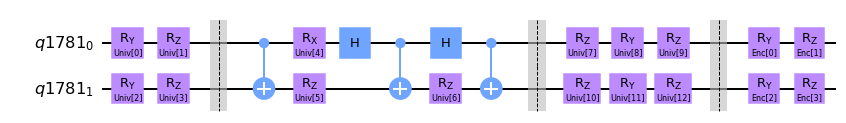

In [35]:
def draw_example():
    quantum_circuit, param_rot, param_enc = build_circuit(n_qubits=2, n_layers=1, opt='universal_encoding')
    return quantum_circuit
draw_example().draw('mpl')

In [36]:
# circuit, rot_params, enc_params = build_circuit(n_qubits=2, n_layers=1)

In [37]:
class PQC_with_DataReuploading(nn.Module):
    def __init__(self, n_qubits, n_layers, output_dim, observables=None, ansatz='base', activation='linear'):
        super().__init__()
        
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.activation = activation
        self.ansatz = ansatz
        
        if observables == None:
            self.observables = Z^n_qubits
        else:
            self.observables = observables
        
        # Build circuits / Parameter Vectors
        self.circuit, self.rot_params, self.enc_params = build_circuit(self.n_qubits, self.n_layers, ansatz)
        self.len_rot_params = len(self.rot_params)
        self.len_enc_params = len(self.enc_params)
        
        self.psi = CircuitStateFn(primitive=self.circuit, coeff=1.)
        self.Op = ~StateFn(self.observables) @ self.psi
        
        # set method to calculcate expected values
        expval = AerPauliExpectation()
        # define gradient method
        gradient = Gradient()
        # define quantum instances (statevector and sample based)
        qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
        # we set shots to 10 as this will determine the number of samples later on.
        qi_qasm = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1000)
        
        self.qnn = OpflowQNN(operator=self.Op, input_params=self.enc_params, weight_params=self.rot_params, 
                             exp_val=expval, gradient=gradient, quantum_instance=qi_sv, input_gradients=True)
        
        self.total_params = []
        for p in self.rot_params:
            self.total_params.append(p)
        for p in self.enc_params:
            self.total_params.append(p)
        
        # Initial Parameters for circuit
#         self.rot_param_vals = nn.Parameter(2*np.pi * torch.rand(len(self.rot_params)))
        self.rot_param_vals = nn.Parameter(2*np.pi * torch.rand(len(self.rot_params)))
#         self.enc_param_vals = nn.Parameter(torch.ones(len(self.enc_params)))
#         self.enc_param_vals  = nn.Parameter(nn.Parameter(torch.rand(len(self.enc_params))))
        self.enc_param_vals  = nn.Parameter(torch.rand(len(self.enc_params)))
        
        # Parameter for circuit output
#         self.w = nn.Parameter(nn.Parameter(torch.rand(self.output_dim)))
        self.w = nn.Parameter(torch.tensor([-5,5], dtype=torch.float32))
        
    def forward(self, inputs):
        input_tiled = self.get_input_tiled(inputs)
        input_scaled = self.enc_param_vals * input_tiled
        input_params = input_scaled
    
        expectation = self.qnn.forward(input_params.detach(), self.rot_param_vals.detach())
        
        action_exp = torch.tensor(expectation) * self.w
        action_prob = F.softmax(action_exp, dim=1)
        
        return action_prob

    def backward(self, inputs):
        input_tiled = self.get_input_tiled(inputs)
        input_scaled = self.enc_param_vals * input_tiled
        input_params = input_scaled
        expectation = self.qnn.forward(input_params.detach(), self.rot_param_vals.detach())
        enc_grad, rot_grad = self.qnn.backward(input_params.detach(), self.rot_param_vals.detach())
        w_grad = torch.tensor(expectation).tile(self.output_dim)
        return torch.tensor(rot_grad.squeeze()), torch.tensor(enc_grad.squeeze()), w_grad
    
    def get_input_tiled(self, inputs):
        # Input: State values -> Need to insert into Encoding gates with scaling parameters(encoding params)
        if self.ansatz == 'universal_encoding' or self.ansatz == 'hw_eff':
            input_tiled = inputs.tile(2)
            input_tiled = input_tiled.tile(self.n_layers)
        elif self.ansatz == 'universal':
            input_tiled = torch.zeros((inputs.shape[0], inputs.shape[1]+1))
            input_tiled[:,:2] = inputs
            input_tiled[:,-1] = inputs[:,-1]
        else:
            input_tiled = inputs.tile(self.n_layers)
        return input_tiled

In [38]:
policy = PQC_with_DataReuploading(n_qubits=2, n_layers=1, output_dim=2, observables=None, ansatz='universal_encoding')

In [39]:
policy.observables

PauliOp(Pauli('ZZ'), coeff=1.0)

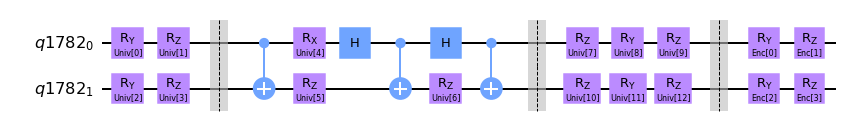

In [40]:
policy.circuit.draw('mpl')

In [41]:
inputs = torch.rand((10,2))

In [42]:
policy.rot_param_vals

Parameter containing:
tensor([4.2154, 0.7716, 0.7426, 3.8365, 2.5541, 0.7770, 1.0969, 3.3640, 5.2640,
        4.2630, 4.6263, 3.0601, 1.3682], requires_grad=True)

In [43]:
policy.enc_param_vals

Parameter containing:
tensor([0.7858, 0.0504, 0.7005, 0.0701], requires_grad=True)

In [44]:
policy.w

Parameter containing:
tensor([-5.,  5.], requires_grad=True)

In [45]:
policy.forward(inputs)

tensor([[0.0238, 0.9762],
        [0.0215, 0.9785],
        [0.0305, 0.9695],
        [0.0397, 0.9603],
        [0.0164, 0.9836],
        [0.0215, 0.9785],
        [0.0280, 0.9720],
        [0.0328, 0.9672],
        [0.0178, 0.9822],
        [0.0148, 0.9852]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)

In [46]:
policy.forward(inputs)

tensor([[0.0238, 0.9762],
        [0.0215, 0.9785],
        [0.0305, 0.9695],
        [0.0397, 0.9603],
        [0.0164, 0.9836],
        [0.0215, 0.9785],
        [0.0280, 0.9720],
        [0.0328, 0.9672],
        [0.0178, 0.9822],
        [0.0148, 0.9852]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)

In [47]:
policy.forward(inputs)

tensor([[0.0238, 0.9762],
        [0.0215, 0.9785],
        [0.0305, 0.9695],
        [0.0397, 0.9603],
        [0.0164, 0.9836],
        [0.0215, 0.9785],
        [0.0280, 0.9720],
        [0.0328, 0.9672],
        [0.0178, 0.9822],
        [0.0148, 0.9852]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)

In [48]:
s = time.time()
a,b,c = policy.backward(inputs)
print(time.time()-s)

1.4906225204467773


# Make Quantum Agent

In [49]:
class QuantumAgent():
    def __init__(self, input_state_dim, n_actions, n_layers=1, ansatz='base'):
        self.policy = PQC_with_DataReuploading(n_qubits=input_state_dim, n_layers=n_layers, 
                                               output_dim=n_actions, observables=None, ansatz=ansatz,
                                               activation='linear')
        self.n_layers = n_layers
        self.variational_optim = torch.optim.Adam([self.policy.rot_param_vals], lr=0.1)
        self.encoding_optim = torch.optim.Adam([self.policy.enc_param_vals], lr=0.1)
        self.weight_optim = torch.optim.Adam([self.policy.w], lr=0.01)
        
        self.lr = 1
        
        self.optims = [self.variational_optim, self.encoding_optim, self.weight_optim]
        
    def get_actions(self, input_state):
        return self.policy.forward(input_state)
    
    def update_policy(self, states, id_action_pairs, returns, action_probs, batch_size):
        r_grad, e_grad, w_grad = self.policy.backward(states)
        
        p_actions = torch.tensor([action_probs[id_action_pairs[i][0], id_action_pairs[i][1]] for i in range(action_probs.shape[0])])
        p_actions = p_actions.reshape(p_actions.shape[0], -1)
        action_idxs = id_action_pairs[:,1]
        
        returns = returns.reshape(returns.shape[0], -1)
        action_weights = agent.policy.w.detach().numpy()[id_action_pairs[:,1]]
        action_weights = action_weights[:,np.newaxis]
        
        w = agent.policy.w.tile(len(states)).reshape(len(states),-1)
        
        rot_grad = returns * ( r_grad * torch.tensor(action_weights) - torch.sum(p_actions * w) * r_grad)
        input_scaled = self.policy.enc_param_vals * self.policy.get_input_tiled(states)
        
        enc_grad = returns * ( e_grad * torch.tensor(action_weights) - input_scaled * torch.sum(p_actions * w) * e_grad)
        weight_grad = returns * ( w_grad * torch.tensor(action_weights) - torch.sum(p_actions * w) * w_grad)
        
        prev = self.policy.rot_param_vals.detach().numpy().copy()
        prev1 = self.policy.enc_param_vals.detach().numpy().copy()
#         prev2 = self.policy.w.detach().numpy().copy()
        
        rot_update = (torch.mean(rot_grad.detach(), dim=0) / batch_size).type(torch.float32)
        enc_update = (torch.mean(enc_grad, dim=0).detach() / batch_size).type(torch.float32)
#         w_update = (torch.mean(weight_grad, dim=0).detach() / batch_size).type(torch.float32)
#         rot_update = torch.mean(rot_grad, dim=0) / batch_size
#         enc_update = torch.mean(enc_grad, dim=0) / batch_size
        
#         self.policy.rot_param_vals += self.lr * rot_update
#         self.policy.enc_param_vals += self.lr * enc_update

#         with torch.no_grad():
    
        self.policy.rot_param_vals.grad = -1*rot_update
        self.policy.enc_param_vals.grad = -1*enc_update
#         self.policy.w.grad = -1*w_update
                
#         print(rot_update)
#         print(enc_update)
        
        self.variational_optim.step()
        self.encoding_optim.step()
#         self.weight_optim.step()

        print(self.policy.rot_param_vals.detach() - prev)
        print(rot_update)
        print(self.policy.enc_param_vals.detach() - prev1)
        print(enc_update)
#         print(self.policy.w.detach() - prev2)
#         print(w_update)
        
#         with torch.no_grad():
#             self.policy.rot_param_vals[self.policy.rot_param_vals > 2*np.pi] = 2*np.pi
#             self.policy.enc_param_vals[self.policy.enc_param_vals > 2*np.pi] = 2*np.pi
#             self.policy.rot_param_vals[self.policy.rot_param_vals < 0] = 0
#             self.policy.enc_param_vals[self.policy.enc_param_vals < 0] = 0
        
#         print(self.policy.rot_param_vals)

In [50]:
n_qubits = 2 # Dimension of the state vectors in CartPole
n_layers = 1
n_actions = 2 # Number of actions in CartPole
agent = QuantumAgent(input_state_dim = n_qubits, n_actions=n_actions, n_layers=n_layers, ansatz='universal_encoding')

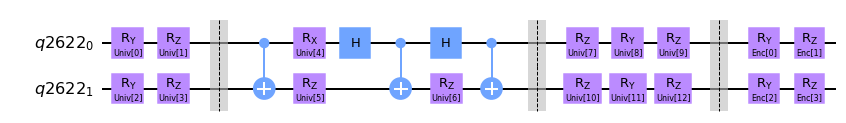

In [51]:
agent.policy.circuit.draw('mpl')

# Run Episodes and Update Policy

In [52]:
def gather_episodes(state_bounds, n_actions, agent, n_episodes, env_name):
    """Interact with environment in batched fashion."""

    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    if env_name == 'Curling':
        envs = [Curling(reward_type='each_end_counts') for _ in range(n_episodes)]
    else:
        envs = [gym.make(env_name) for _ in range(n_episodes)]

    done = [False for _ in range(n_episodes)]
    states = [e.reset() for e in envs]

    while not all(done):
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]
        normalized_states = [s/state_bounds for i, s in enumerate(states) if not done[i]]

        for i, state in zip(unfinished_ids, normalized_states):
            trajectories[i]['states'].append(state)

        states = torch.from_numpy(np.array(normalized_states))
        action_probs = agent.get_actions(states)

        # Store action and transition all environments to the next state
        states = [None for i in range(n_episodes)]
        for i, action_prob in zip(unfinished_ids, action_probs.detach().numpy()):
            action = np.random.choice(n_actions, p=action_prob)
            states[i], reward, done[i], _ = envs[i].step(action)
            trajectories[i]['actions'].append(action)
            trajectories[i]['rewards'].append(reward)
            trajectories[i]['action probs'].append(action_prob)

    return trajectories

def compute_returns(rewards_history, gamma):
    """Compute discounted returns with discount factor `gamma`."""
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns

In [53]:
env_name = "Curling"
# env_name = "Curling"
if env_name == "CartPole-v1":
    state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
elif env_name == 'Curling':
    state_bounds = np.array([3, 1])
gamma = 1
batch_size = 10
n_episodes = 1000

In [ ]:
# Start training the agent
episode_reward_history = []
# Monitoring reward
monitor_reward_history = []
for batch in tqdm(range(n_episodes // batch_size)):
    # Gather episodes
    episodes = gather_episodes(state_bounds, n_actions, agent, batch_size, env_name)

    # Group states, actions and returns in numpy arrays
    states = torch.from_numpy(np.concatenate([ep['states'] for ep in episodes]))
    actions = torch.from_numpy(np.concatenate([ep['actions'] for ep in episodes]))
    action_probs = torch.from_numpy(np.concatenate([ep['action probs'] for ep in episodes]))
    rewards = [ep['rewards'] for ep in episodes]
    returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
    returns = torch.from_numpy(np.array(returns))

    id_action_pairs = torch.from_numpy(np.array([[i, a] for i, a in enumerate(actions)]))

    # Update model parameters.
    agent.update_policy(states, id_action_pairs, returns, action_probs, batch_size)
    print(action_probs)

    if batch % 5 == 1:
        # Gather episodes
        episodes = gather_episodes(state_bounds, n_actions, agent, 50, env_name)

        # Group states, actions and returns in numpy arrays
        states = torch.from_numpy(np.concatenate([ep['states'] for ep in episodes]))
        actions = torch.from_numpy(np.concatenate([ep['actions'] for ep in episodes]))
        action_probs = torch.from_numpy(np.concatenate([ep['action probs'] for ep in episodes]))
        rewards = [ep['rewards'] for ep in episodes]
        # Store collected rewards
        temp_hist = []
        for ep_rwds in rewards:
            temp_hist.append(np.sum(ep_rwds))
        avg_rewards = np.mean(temp_hist)
        monitor_reward_history.append(avg_rewards)
        
        print('Monitored episode', 50,
              'Average Monitored rewards: ', avg_rewards)

    # Store collected rewards
    for ep_rwds in rewards:
        episode_reward_history.append(np.sum(ep_rwds))

    avg_rewards = np.mean(episode_reward_history[-batch_size:])

    print('Finished episode', (batch + 1) * batch_size,
          'Average rewards: ', avg_rewards)

    if avg_rewards >= 500.0:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([ 0.1000,  0.1000,  0.1000, -0.1000,  0.1000,  0.1000,  0.1000, -0.1000,
         0.1000, -0.1000,  0.1000, -0.1000, -0.1000])
tensor([ 0.0370,  0.0049,  0.0065, -0.0197,  0.0379,  0.0077,  0.0214, -0.0097,
         0.0026, -0.0106,  0.0128, -0.0079, -0.0089])
tensor([-0.1000,  0.0000,  0.1000,  0.0000])
tensor([-5.5671e-03, -9.6785e-19,  1.2584e-02,  0.0000e+00])
tensor([[0.7862, 0.2138],
        [0.7862, 0.2138],
        [0.7171, 0.2829],
        [0.7171, 0.2829],
        [0.7171, 0.2829],
        [0.7171, 0.2829],
        [0.7862, 0.2138],
        [0.7171, 0.2829],
        [0.7171, 0.2829],
        [0.7171, 0.2829],
        [0.7862, 0.2138],
        [0.7862, 0.2138],
        [0.7862, 0.2138],
        [0.8388, 0.1612],
        [0.8749, 0.1251],
        [0.9035, 0.0965],
        [0.8878, 0.1122],
        [0.7876, 0.2124],
        [0.7876, 0.2124],
        [0.5317, 0.4683],
        [0.7862, 0.2138],
        [0.6361, 0.3639],
        [0.6361, 0.3639],
        [0.6361, 0.3639],
  

tensor([ 0.0481,  0.0279,  0.0580, -0.0350,  0.0532,  0.0816,  0.0708, -0.0650,
         0.0606, -0.0917,  0.0890, -0.0539, -0.0904])
tensor([ 0.0143,  0.0209,  0.0437, -0.0030,  0.0178,  0.0161,  0.0366, -0.0126,
         0.0304, -0.0066,  0.0213, -0.0163, -0.0143])
tensor([0.0036, 0.0000, 0.0731, 0.0000])
tensor([-2.1974e-03,  7.3171e-19,  2.7327e-02,  0.0000e+00])
tensor([[0.0166, 0.9834],
        [0.0701, 0.9299],
        [0.8652, 0.1348],
        [0.8652, 0.1348],
        [0.5772, 0.4228],
        [0.0701, 0.9299],
        [0.0166, 0.9834],
        [0.0280, 0.9720],
        [0.2049, 0.7951],
        [0.0693, 0.9307],
        [0.0166, 0.9834],
        [0.0166, 0.9834],
        [0.0701, 0.9299],
        [0.2253, 0.7747],
        [0.2253, 0.7747],
        [0.2253, 0.7747],
        [0.8652, 0.1348],
        [0.9611, 0.0389],
        [0.9849, 0.0151],
        [0.9904, 0.0096],
        [0.9891, 0.0109],
        [0.0166, 0.9834],
        [0.0693, 0.9307],
        [0.0168, 0.9832],
      

tensor([ 0.0408, -0.0449,  0.0014, -0.0336,  0.0447, -0.0043,  0.0339,  0.0420,
        -0.0010, -0.0708,  0.0765,  0.0371,  0.0350])
tensor([ 0.0145, -0.0300, -0.0350, -0.0131,  0.0150, -0.0226, -0.0123,  0.0225,
        -0.0297, -0.0030,  0.0007,  0.0221,  0.0334])
tensor([0.0486, 0.0000, 0.0180, 0.0000])
tensor([ 5.7741e-03,  2.0954e-18, -1.7809e-02,  0.0000e+00])
tensor([[0.0318, 0.9682],
        [0.9595, 0.0405],
        [0.9862, 0.0138],
        [0.9684, 0.0316],
        [0.9871, 0.0129],
        [0.9871, 0.0129],
        [0.9862, 0.0138],
        [0.9595, 0.0405],
        [0.7738, 0.2262],
        [0.2429, 0.7571],
        [0.0318, 0.9682],
        [0.0318, 0.9682],
        [0.0061, 0.9939],
        [0.0318, 0.9682],
        [0.7738, 0.2262],
        [0.7738, 0.2262],
        [0.9595, 0.0405],
        [0.9862, 0.0138],
        [0.9871, 0.0129],
        [0.9684, 0.0316],
        [0.0318, 0.9682],
        [0.7738, 0.2262],
        [0.9595, 0.0405],
        [0.9595, 0.0405],
      

tensor([ 0.0580, -0.0485, -0.0250, -0.0525,  0.0621, -0.0468,  0.0386,  0.0136,
        -0.0354, -0.0319,  0.0056,  0.0059,  0.0549])
tensor([ 0.0482,  0.0110, -0.0595, -0.0455,  0.0442, -0.0467,  0.0057, -0.0517,
        -0.0935,  0.0034, -0.0724, -0.0365, -0.0053])
tensor([-0.0138,  0.0000, -0.0001,  0.0000])
tensor([-1.0087e-01, -1.3168e-19, -2.2536e-02,  0.0000e+00])
tensor([[6.9477e-02, 9.3052e-01],
        [4.8164e-03, 9.9518e-01],
        [9.0887e-03, 9.9091e-01],
        [4.8164e-03, 9.9518e-01],
        [6.9477e-02, 9.3052e-01],
        [1.1528e-02, 9.8847e-01],
        [9.0887e-03, 9.9091e-01],
        [7.9554e-02, 9.2045e-01],
        [9.0887e-03, 9.9091e-01],
        [1.1528e-02, 9.8847e-01],
        [6.9477e-02, 9.3052e-01],
        [3.6348e-01, 6.3652e-01],
        [6.9477e-02, 9.3052e-01],
        [4.8164e-03, 9.9518e-01],
        [6.9477e-02, 9.3052e-01],
        [6.9477e-02, 9.3052e-01],
        [1.1528e-02, 9.8847e-01],
        [6.9477e-02, 9.3052e-01],
        [7.660

Monitored episode 50 Average Monitored rewards:  54.24
Finished episode 120 Average rewards:  84.7
tensor([ 0.0253, -0.0116, -0.0229, -0.0538,  0.0321, -0.0397,  0.0321, -0.0209,
        -0.0258, -0.0515, -0.0102,  0.0107, -0.0045])
tensor([-0.0180, -0.0012,  0.0138,  0.0009, -0.0185, -0.0014, -0.0123,  0.0204,
         0.0237,  0.0067,  0.0160,  0.0165,  0.0076])
tensor([-0.0234,  0.0000, -0.0238,  0.0000])
tensor([ 3.0532e-02, -2.9168e-18, -2.5181e-03,  0.0000e+00])
tensor([[1.9609e-03, 9.9804e-01],
        [2.5667e-03, 9.9743e-01],
        [2.5667e-03, 9.9743e-01],
        [2.3095e-02, 9.7691e-01],
        [2.5667e-03, 9.9743e-01],
        [1.9609e-03, 9.9804e-01],
        [1.9609e-03, 9.9804e-01],
        [1.1284e-03, 9.9887e-01],
        [1.9609e-03, 9.9804e-01],
        [2.5667e-03, 9.9743e-01],
        [1.9609e-03, 9.9804e-01],
        [1.9609e-03, 9.9804e-01],
        [2.3095e-02, 9.7691e-01],
        [2.3095e-02, 9.7691e-01],
        [9.6302e-01, 3.6975e-02],
        [9.9870e-

tensor([ 0.0066, -0.0044, -0.0061, -0.0288,  0.0057, -0.0209, -0.0020, -0.0145,
        -0.0047, -0.0284,  0.0010,  0.0081, -0.0095])
tensor([-0.0189,  0.0036,  0.0454,  0.0133, -0.0080,  0.0175,  0.0015, -0.0046,
         0.0521, -0.0038,  0.0444,  0.0083, -0.0281])
tensor([-0.0075,  0.0000, -0.0058,  0.0000])
tensor([ 4.0933e-02, -7.4193e-19,  2.2328e-02,  0.0000e+00])
tensor([[4.3303e-04, 9.9957e-01],
        [5.9310e-02, 9.4069e-01],
        [5.5124e-03, 9.9449e-01],
        [4.3303e-04, 9.9957e-01],
        [9.2055e-04, 9.9908e-01],
        [5.9310e-02, 9.4069e-01],
        [5.9310e-02, 9.4069e-01],
        [5.5124e-03, 9.9449e-01],
        [4.5591e-01, 5.4409e-01],
        [9.7650e-01, 2.3503e-02],
        [4.3303e-04, 9.9957e-01],
        [5.9310e-02, 9.4069e-01],
        [8.9134e-01, 1.0866e-01],
        [8.9134e-01, 1.0866e-01],
        [9.7650e-01, 2.3503e-02],
        [9.8906e-01, 1.0943e-02],
        [9.8906e-01, 1.0943e-02],
        [9.8831e-01, 1.1687e-02],
        [9.883

tensor([-0.0263,  0.0010,  0.0151, -0.0015, -0.0135,  0.0059, -0.0314,  0.0026,
         0.0254, -0.0346,  0.0210,  0.0419, -0.0183])
tensor([-0.0240,  0.0061,  0.0310,  0.0175, -0.0061,  0.0235, -0.0111, -0.0056,
         0.0493, -0.0189,  0.0301,  0.0183, -0.0367])
tensor([ 0.0228,  0.0000, -0.0128,  0.0000])
tensor([4.3380e-02, 2.6665e-18, 4.7106e-03, 0.0000e+00])
tensor([[7.1432e-04, 9.9929e-01],
        [5.3657e-03, 9.9463e-01],
        [7.8168e-01, 2.1832e-01],
        [9.4260e-01, 5.7402e-02],
        [9.7310e-01, 2.6900e-02],
        [9.7310e-01, 2.6900e-02],
        [9.7430e-01, 2.5702e-02],
        [9.7430e-01, 2.5702e-02],
        [9.5619e-01, 4.3808e-02],
        [8.9875e-01, 1.0125e-01],
        [7.1432e-04, 9.9929e-01],
        [1.3606e-03, 9.9864e-01],
        [7.1432e-04, 9.9929e-01],
        [1.1438e-01, 8.8562e-01],
        [9.9923e-01, 7.6969e-04],
        [9.9985e-01, 1.4926e-04],
        [9.9989e-01, 1.1282e-04],
        [9.9989e-01, 1.1282e-04],
        [9.9964e-0

tensor([-0.0217,  0.0006,  0.0374,  0.0202, -0.0245,  0.0190, -0.0361,  0.0091,
         0.0404,  0.0166,  0.0413,  0.0207, -0.0142])
tensor([-0.0030, -0.0069, -0.0123,  0.0018, -0.0103, -0.0070, -0.0149,  0.0348,
        -0.0083,  0.0108, -0.0074,  0.0090,  0.0361])
tensor([0.0368, 0.0000, 0.0263, 0.0000])
tensor([ 8.8999e-03,  7.0025e-19, -8.7175e-03,  0.0000e+00])
tensor([[5.6000e-03, 9.9440e-01],
        [3.0292e-02, 9.6971e-01],
        [4.8813e-03, 9.9512e-01],
        [3.4222e-02, 9.6578e-01],
        [4.2644e-01, 5.7356e-01],
        [9.6119e-01, 3.8806e-02],
        [9.9837e-01, 1.6310e-03],
        [9.9981e-01, 1.8648e-04],
        [9.9837e-01, 1.6310e-03],
        [9.6119e-01, 3.8806e-02],
        [5.6000e-03, 9.9440e-01],
        [4.8813e-03, 9.9512e-01],
        [3.4222e-02, 9.6578e-01],
        [4.8813e-03, 9.9512e-01],
        [5.6000e-03, 9.9440e-01],
        [2.0568e-01, 7.9432e-01],
        [8.6429e-01, 1.3571e-01],
        [4.1479e-01, 5.8521e-01],
        [1.3824e-0

tensor([ 0.0182,  0.0022,  0.0206,  0.0328, -0.0128,  0.0206, -0.0211, -0.0093,
         0.0090,  0.0603,  0.0191, -0.0397, -0.0126])
tensor([ 0.0268,  0.0040,  0.0330,  0.0189,  0.0038,  0.0142,  0.0075, -0.0238,
         0.0097,  0.0395,  0.0257, -0.0497, -0.0228])
tensor([0.0009, 0.0000, 0.0418, 0.0000])
tensor([-1.0848e-02, -8.7389e-19,  5.0775e-02,  0.0000e+00])
tensor([[2.7992e-02, 9.7201e-01],
        [3.1839e-03, 9.9682e-01],
        [2.7992e-02, 9.7201e-01],
        [2.4372e-01, 7.5628e-01],
        [8.9627e-01, 1.0373e-01],
        [8.7197e-01, 1.2803e-01],
        [6.0602e-01, 3.9398e-01],
        [1.5037e-01, 8.4963e-01],
        [6.0602e-01, 3.9398e-01],
        [8.7197e-01, 1.2803e-01],
        [2.7992e-02, 9.7201e-01],
        [3.1839e-03, 9.9682e-01],
        [1.8116e-01, 8.1884e-01],
        [1.1929e-02, 9.8807e-01],
        [1.8116e-01, 8.1884e-01],
        [9.9769e-01, 2.3118e-03],
        [9.9984e-01, 1.6448e-04],
        [9.9984e-01, 1.6448e-04],
        [9.9968e-0

Monitored episode 50 Average Monitored rewards:  63.0
Finished episode 270 Average rewards:  71.6
tensor([ 0.0526, -0.0042, -0.0332,  0.0143,  0.0158, -0.0095, -0.0163, -0.0159,
        -0.0451,  0.0825, -0.0351, -0.0693,  0.0074])
tensor([ 0.0403, -0.0045, -0.0709, -0.0099,  0.0178, -0.0201, -0.0022, -0.0023,
        -0.0926,  0.0330, -0.0719, -0.0562,  0.0234])
tensor([-0.0416,  0.0000,  0.0113,  0.0000])
tensor([-7.2389e-02,  3.8253e-19, -1.9677e-02,  0.0000e+00])
tensor([[6.8502e-03, 9.9315e-01],
        [6.8502e-03, 9.9315e-01],
        [6.8502e-03, 9.9315e-01],
        [6.8502e-03, 9.9315e-01],
        [1.0156e-01, 8.9844e-01],
        [9.2015e-01, 7.9847e-02],
        [9.5469e-01, 4.5306e-02],
        [9.1782e-01, 8.2179e-02],
        [7.3333e-01, 2.6667e-01],
        [2.2065e-01, 7.7935e-01],
        [6.8502e-03, 9.9315e-01],
        [3.5915e-03, 9.9641e-01],
        [8.7719e-01, 1.2281e-01],
        [8.7719e-01, 1.2281e-01],
        [9.9777e-01, 2.2299e-03],
        [9.9777e-0

tensor([ 0.0154, -0.0005,  0.0165,  0.0238, -0.0014,  0.0110,  0.0055, -0.0174,
         0.0056,  0.0391,  0.0145, -0.0312, -0.0062])
tensor([-0.0116,  0.0059,  0.0726,  0.0091, -0.0076,  0.0144,  0.0162, -0.0515,
         0.0761, -0.0193,  0.0690, -0.0007, -0.0457])
tensor([-0.0114,  0.0000,  0.0419,  0.0000])
tensor([-3.0544e-04,  1.0067e-18,  5.9728e-02,  0.0000e+00])
tensor([[7.8780e-04, 9.9921e-01],
        [4.1601e-03, 9.9584e-01],
        [2.2311e-04, 9.9978e-01],
        [3.8626e-04, 9.9961e-01],
        [2.2311e-04, 9.9978e-01],
        [1.0877e-02, 9.8912e-01],
        [7.8780e-04, 9.9921e-01],
        [3.8626e-04, 9.9961e-01],
        [1.5429e-01, 8.4571e-01],
        [4.1601e-03, 9.9584e-01],
        [7.8780e-04, 9.9921e-01],
        [2.2858e-01, 7.7142e-01],
        [1.0877e-02, 9.8912e-01],
        [1.0877e-02, 9.8912e-01],
        [1.0877e-02, 9.8912e-01],
        [7.8780e-04, 9.9921e-01],
        [1.0877e-02, 9.8912e-01],
        [1.0877e-02, 9.8912e-01],
        [8.749

tensor([-0.0061, -0.0066,  0.0125,  0.0111, -0.0059,  0.0012, -0.0005,  0.0144,
         0.0074,  0.0234,  0.0124,  0.0022,  0.0189])
tensor([-0.0185,  0.0011,  0.0087, -0.0040, -0.0067, -0.0014,  0.0056, -0.0083,
         0.0178, -0.0265,  0.0085,  0.0265, -0.0149])
tensor([0.0108, 0.0000, 0.0073, 0.0000])
tensor([ 8.0445e-03, -7.5649e-18, -9.3040e-03,  0.0000e+00])
tensor([[1.4120e-03, 9.9859e-01],
        [3.8171e-01, 6.1829e-01],
        [2.2347e-02, 9.7765e-01],
        [9.2662e-01, 7.3379e-02],
        [9.9062e-01, 9.3779e-03],
        [9.2662e-01, 7.3379e-02],
        [3.8171e-01, 6.1829e-01],
        [9.2662e-01, 7.3379e-02],
        [3.8171e-01, 6.1829e-01],
        [9.2662e-01, 7.3379e-02],
        [1.4120e-03, 9.9859e-01],
        [9.2662e-01, 7.3379e-02],
        [9.9062e-01, 9.3779e-03],
        [9.9623e-01, 3.7690e-03],
        [9.9623e-01, 3.7690e-03],
        [9.9506e-01, 4.9376e-03],
        [9.8414e-01, 1.5861e-02],
        [6.6997e-01, 3.3003e-01],
        [9.2122e-0

tensor([-2.5406e-02, -8.3923e-05,  4.0607e-02,  2.2849e-02, -1.9175e-02,
         2.0350e-02,  2.7351e-02, -5.5832e-03,  3.5195e-02, -7.6100e-03,
         3.9545e-02,  1.7294e-02,  1.7738e-04])
tensor([-0.0165, -0.0022,  0.0380,  0.0083, -0.0053,  0.0090,  0.0045,  0.0214,
         0.0425, -0.0016,  0.0400,  0.0224,  0.0235])
tensor([0.0114, 0.0000, 0.0303, 0.0000])
tensor([3.7501e-02, 4.3154e-18, 9.0497e-03, 0.0000e+00])
tensor([[9.6742e-03, 9.9033e-01],
        [7.3841e-04, 9.9926e-01],
        [6.2770e-02, 9.3723e-01],
        [6.2770e-02, 9.3723e-01],
        [1.2610e-03, 9.9874e-01],
        [9.6742e-03, 9.9033e-01],
        [9.6742e-03, 9.9033e-01],
        [7.1017e-01, 2.8983e-01],
        [9.4690e-01, 5.3101e-02],
        [9.7856e-01, 2.1436e-02],
        [9.6742e-03, 9.9033e-01],
        [1.3873e-01, 8.6127e-01],
        [1.2610e-03, 9.9874e-01],
        [9.6742e-03, 9.9033e-01],
        [1.2610e-03, 9.9874e-01],
        [2.9045e-03, 9.9710e-01],
        [8.1605e-01, 1.8395e-0

tensor([-0.0247,  0.0011,  0.0291,  0.0108, -0.0114,  0.0131,  0.0283, -0.0038,
         0.0263, -0.0195,  0.0286,  0.0242,  0.0014])
tensor([ 0.0069,  0.0037, -0.0137, -0.0075,  0.0077, -0.0048,  0.0088, -0.0243,
        -0.0182, -0.0029, -0.0166, -0.0038, -0.0211])
tensor([0.0098, 0.0000, 0.0117, 0.0000])
tensor([-2.9579e-02, -1.5747e-18, -6.1258e-03,  0.0000e+00])
tensor([[2.2126e-01, 7.7874e-01],
        [2.8102e-03, 9.9719e-01],
        [1.8965e-02, 9.8103e-01],
        [7.4149e-01, 2.5851e-01],
        [8.9904e-01, 1.0096e-01],
        [8.7715e-01, 1.2285e-01],
        [8.9904e-01, 1.0096e-01],
        [8.9904e-01, 1.0096e-01],
        [7.4149e-01, 2.5851e-01],
        [8.9904e-01, 1.0096e-01],
        [2.2126e-01, 7.7874e-01],
        [2.2126e-01, 7.7874e-01],
        [1.8965e-02, 9.8103e-01],
        [2.8102e-03, 9.9719e-01],
        [2.8102e-03, 9.9719e-01],
        [1.7943e-02, 9.8206e-01],
        [4.5250e-01, 5.4750e-01],
        [9.9989e-01, 1.0926e-04],
        [9.7158e-0

Monitored episode 50 Average Monitored rewards:  50.02
Finished episode 420 Average rewards:  73.3
tensor([ 0.0070,  0.0001,  0.0222,  0.0050,  0.0221,  0.0020,  0.0403, -0.0088,
         0.0123,  0.0211,  0.0199, -0.0066, -0.0079])
tensor([ 0.0234,  0.0045, -0.0075, -0.0046,  0.0224, -0.0040,  0.0178, -0.0295,
        -0.0250,  0.0231, -0.0141, -0.0253, -0.0303])
tensor([-0.0020,  0.0000,  0.0275,  0.0000])
tensor([-4.0039e-02, -6.4104e-19,  1.1390e-02,  0.0000e+00])
tensor([[8.1764e-01, 1.8236e-01],
        [9.7160e-01, 2.8405e-02],
        [8.1764e-01, 1.8236e-01],
        [1.2931e-01, 8.7069e-01],
        [8.1764e-01, 1.8236e-01],
        [9.6831e-01, 3.1687e-02],
        [8.1087e-01, 1.8913e-01],
        [2.3429e-01, 7.6571e-01],
        [8.1087e-01, 1.8913e-01],
        [8.1087e-01, 1.8913e-01],
        [8.1764e-01, 1.8236e-01],
        [5.6710e-03, 9.9433e-01],
        [4.2348e-03, 9.9577e-01],
        [1.2675e-03, 9.9873e-01],
        [4.2348e-03, 9.9577e-01],
        [4.2348e-

tensor([ 0.0277,  0.0093,  0.0067, -0.0022,  0.0466, -0.0034,  0.0572, -0.0277,
        -0.0060,  0.0456,  0.0022, -0.0220, -0.0319])
tensor([ 0.0126,  0.0056,  0.0104,  0.0047,  0.0124,  0.0072,  0.0188, -0.0343,
        -0.0019,  0.0199,  0.0055, -0.0135, -0.0344])
tensor([-0.0241,  0.0000,  0.0239,  0.0000])
tensor([-3.4645e-02, -1.3477e-18,  1.7592e-02,  0.0000e+00])
tensor([[8.9480e-01, 1.0520e-01],
        [9.8931e-01, 1.0688e-02],
        [9.8894e-01, 1.1057e-02],
        [9.8894e-01, 1.1057e-02],
        [9.1617e-01, 8.3833e-02],
        [3.8191e-01, 6.1809e-01],
        [3.8191e-01, 6.1809e-01],
        [9.8894e-01, 1.1057e-02],
        [9.8931e-01, 1.0688e-02],
        [1.3791e-01, 8.6209e-01],
        [8.9480e-01, 1.0520e-01],
        [8.9480e-01, 1.0520e-01],
        [8.9480e-01, 1.0520e-01],
        [8.9480e-01, 1.0520e-01],
        [8.9480e-01, 1.0520e-01],
        [3.3881e-03, 9.9661e-01],
        [1.6231e-03, 9.9838e-01],
        [1.3791e-01, 8.6209e-01],
        [1.623

tensor([ 0.0375,  0.0032, -0.0023,  0.0019,  0.0439, -0.0061,  0.0349, -0.0130,
        -0.0102,  0.0651, -0.0049, -0.0356, -0.0280])
tensor([ 0.0166, -0.0015, -0.0331, -0.0032,  0.0070, -0.0074, -0.0063,  0.0100,
        -0.0268,  0.0229, -0.0315, -0.0211, -0.0093])
tensor([-0.0147,  0.0000,  0.0242,  0.0000])
tensor([ 1.5470e-03,  1.5992e-19, -1.0139e-02,  0.0000e+00])
tensor([[9.2135e-01, 7.8652e-02],
        [9.9665e-01, 3.3468e-03],
        [9.9822e-01, 1.7794e-03],
        [9.8814e-01, 1.1858e-02],
        [9.8814e-01, 1.1858e-02],
        [7.4918e-01, 2.5082e-01],
        [2.2709e-02, 9.7729e-01],
        [1.1207e-01, 8.8793e-01],
        [9.8814e-01, 1.1858e-02],
        [9.9822e-01, 1.7794e-03],
        [9.2135e-01, 7.8652e-02],
        [9.5637e-02, 9.0436e-01],
        [9.9822e-01, 1.7794e-03],
        [9.8814e-01, 1.1858e-02],
        [9.8814e-01, 1.1858e-02],
        [7.4918e-01, 2.5082e-01],
        [2.2709e-02, 9.7729e-01],
        [1.4116e-01, 8.5884e-01],
        [8.210

tensor([ 0.0220, -0.0011,  0.0155,  0.0246,  0.0183,  0.0148,  0.0014,  0.0100,
         0.0062,  0.0529,  0.0147, -0.0297, -0.0025])
tensor([-0.0054, -0.0006,  0.0237,  0.0117, -0.0072,  0.0114, -0.0099,  0.0196,
         0.0214,  0.0021,  0.0250, -0.0014,  0.0164])
tensor([0.0057, 0.0000, 0.0377, 0.0000])
tensor([2.0245e-02, 2.9007e-19, 1.7511e-02, 0.0000e+00])
tensor([[9.3187e-01, 6.8130e-02],
        [9.8801e-02, 9.0120e-01],
        [2.1134e-04, 9.9979e-01],
        [9.6750e-01, 3.2503e-02],
        [9.9967e-01, 3.3277e-04],
        [9.9911e-01, 8.9068e-04],
        [9.9911e-01, 8.9068e-04],
        [8.3890e-01, 1.6110e-01],
        [1.1435e-02, 9.8857e-01],
        [1.7764e-03, 9.9822e-01],
        [9.3187e-01, 6.8130e-02],
        [9.9742e-01, 2.5848e-03],
        [9.9868e-01, 1.3155e-03],
        [9.9087e-01, 9.1284e-03],
        [9.9087e-01, 9.1284e-03],
        [7.7412e-01, 2.2588e-01],
        [1.0425e-01, 8.9575e-01],
        [1.0425e-01, 8.9575e-01],
        [7.7412e-01, 2

tensor([ 0.0075, -0.0009,  0.0285,  0.0412,  0.0037,  0.0321, -0.0145,  0.0201,
         0.0172,  0.0331,  0.0279, -0.0199,  0.0143])
tensor([-0.0020,  0.0001,  0.0020,  0.0048, -0.0068,  0.0049, -0.0148,  0.0247,
         0.0041, -0.0021,  0.0035,  0.0005,  0.0138])
tensor([0.0141, 0.0000, 0.0423, 0.0000])
tensor([ 2.4481e-02, -1.8293e-18, -2.2354e-03,  0.0000e+00])
tensor([[9.8556e-01, 1.4436e-02],
        [9.8556e-01, 1.4436e-02],
        [9.9812e-01, 1.8830e-03],
        [9.9525e-01, 4.7527e-03],
        [9.1040e-01, 8.9599e-02],
        [9.9525e-01, 4.7527e-03],
        [9.9812e-01, 1.8830e-03],
        [9.8556e-01, 1.4436e-02],
        [5.8736e-03, 9.9413e-01],
        [5.8736e-03, 9.9413e-01],
        [9.8556e-01, 1.4436e-02],
        [9.9525e-01, 4.7527e-03],
        [9.1040e-01, 8.9599e-02],
        [2.5098e-01, 7.4902e-01],
        [3.5042e-02, 9.6496e-01],
        [2.5070e-02, 9.7493e-01],
        [3.0140e-01, 6.9860e-01],
        [5.9411e-01, 4.0589e-01],
        [6.9451e-0

Monitored episode 50 Average Monitored rewards:  45.3
Finished episode 570 Average rewards:  26.7
tensor([ 9.3889e-03, -5.0545e-05,  1.7649e-02,  3.3274e-02, -2.9154e-03,
         2.6732e-02, -2.8789e-02,  2.7486e-02,  1.1887e-02,  2.2673e-02,
         1.9359e-02, -1.6427e-02,  1.4636e-02])
tensor([ 0.0140,  0.0009, -0.0314, -0.0080, -0.0051, -0.0073, -0.0295,  0.0527,
        -0.0202, -0.0072, -0.0257, -0.0078,  0.0104])
tensor([0.0210, 0.0000, 0.0289, 0.0000])
tensor([ 5.5822e-02, -8.0697e-19, -2.1737e-02,  0.0000e+00])
tensor([[9.9592e-01, 4.0757e-03],
        [9.9592e-01, 4.0757e-03],
        [5.1024e-02, 9.4898e-01],
        [9.9592e-01, 4.0757e-03],
        [9.9550e-01, 4.4979e-03],
        [9.9592e-01, 4.0757e-03],
        [9.0622e-01, 9.3783e-02],
        [5.1024e-02, 9.4898e-01],
        [9.0622e-01, 9.3783e-02],
        [9.9592e-01, 4.0757e-03],
        [9.9592e-01, 4.0757e-03],
        [9.0622e-01, 9.3783e-02],
        [5.1024e-02, 9.4898e-01],
        [9.0622e-01, 9.3783e-0

tensor([ 0.0026, -0.0024, -0.0010,  0.0042,  0.0042,  0.0005,  0.0029,  0.0076,
        -0.0013,  0.0181,  0.0015, -0.0006, -0.0058])
tensor([-0.0092, -0.0019,  0.0078, -0.0014,  0.0075, -0.0026,  0.0286, -0.0462,
         0.0002,  0.0109,  0.0053,  0.0113, -0.0207])
tensor([0.0080, 0.0000, 0.0048, 0.0000])
tensor([-4.4965e-02,  3.9633e-18,  6.1088e-03,  0.0000e+00])
tensor([[9.9375e-01, 6.2487e-03],
        [9.7261e-01, 2.7391e-02],
        [1.7756e-01, 8.2244e-01],
        [5.0724e-01, 4.9276e-01],
        [7.4290e-01, 2.5710e-01],
        [7.4290e-01, 2.5710e-01],
        [1.1368e-01, 8.8632e-01],
        [1.1368e-01, 8.8632e-01],
        [3.9427e-02, 9.6057e-01],
        [9.9926e-01, 7.3736e-04],
        [9.9375e-01, 6.2487e-03],
        [9.6355e-01, 3.6448e-02],
        [1.9868e-01, 8.0132e-01],
        [3.2780e-04, 9.9967e-01],
        [8.0787e-01, 1.9213e-01],
        [9.9994e-01, 6.1000e-05],
        [9.9951e-01, 4.9056e-04],
        [9.9951e-01, 4.9056e-04],
        [8.0787e-0

tensor([-0.0085, -0.0059, -0.0098, -0.0152,  0.0107, -0.0180,  0.0381, -0.0184,
        -0.0084,  0.0169, -0.0081,  0.0142, -0.0239])
tensor([ 0.0056, -0.0006, -0.0052, -0.0037,  0.0054, -0.0038,  0.0075, -0.0111,
        -0.0077,  0.0067, -0.0030, -0.0017, -0.0132])
tensor([-0.0112,  0.0000, -0.0086,  0.0000])
tensor([-8.5602e-03,  1.8337e-18,  3.9952e-03,  0.0000e+00])
tensor([[9.9367e-01, 6.3308e-03],
        [9.3505e-01, 6.4947e-02],
        [9.8525e-01, 1.4745e-02],
        [8.1736e-01, 1.8264e-01],
        [3.0727e-01, 6.9273e-01],
        [3.0727e-01, 6.9273e-01],
        [3.0727e-01, 6.9273e-01],
        [9.8525e-01, 1.4745e-02],
        [9.9367e-01, 6.3308e-03],
        [9.3505e-01, 6.4947e-02],
        [9.9367e-01, 6.3308e-03],
        [9.8525e-01, 1.4745e-02],
        [8.1736e-01, 1.8264e-01],
        [3.0727e-01, 6.9273e-01],
        [2.0542e-01, 7.9458e-01],
        [3.8450e-01, 6.1550e-01],
        [4.1864e-01, 5.8136e-01],
        [3.8450e-01, 6.1550e-01],
        [2.054

tensor([-0.0233, -0.0039,  0.0111,  0.0137, -0.0044,  0.0088,  0.0294, -0.0200,
         0.0066, -0.0094,  0.0098,  0.0202, -0.0030])
tensor([-0.0236, -0.0006,  0.0412,  0.0149, -0.0052,  0.0140,  0.0218, -0.0461,
         0.0293, -0.0068,  0.0334,  0.0157,  0.0046])
tensor([-0.0169,  0.0000,  0.0020,  0.0000])
tensor([-5.2654e-02, -5.1556e-18,  1.8965e-02,  0.0000e+00])
tensor([[9.9535e-01, 4.6468e-03],
        [9.9522e-01, 4.7803e-03],
        [9.4149e-01, 5.8511e-02],
        [4.4025e-01, 5.5975e-01],
        [1.2865e-01, 8.7135e-01],
        [9.4149e-01, 5.8511e-02],
        [9.9522e-01, 4.7803e-03],
        [9.9535e-01, 4.6468e-03],
        [9.9522e-01, 4.7803e-03],
        [9.9522e-01, 4.7803e-03],
        [9.9535e-01, 4.6468e-03],
        [9.9535e-01, 4.6468e-03],
        [9.4149e-01, 5.8511e-02],
        [4.4025e-01, 5.5975e-01],
        [9.4149e-01, 5.8511e-02],
        [9.9522e-01, 4.7803e-03],
        [8.8727e-01, 1.1273e-01],
        [9.9522e-01, 4.7803e-03],
        [9.414

tensor([-9.1581e-03, -3.4337e-03, -2.7628e-03, -9.9802e-04,  4.5300e-05,
        -4.0331e-03,  1.4708e-02, -7.8850e-03, -2.7443e-03, -1.4727e-02,
        -1.6407e-03,  1.7672e-02, -3.9001e-03])
tensor([ 0.0129, -0.0006, -0.0049,  0.0006,  0.0022,  0.0001, -0.0131,  0.0228,
        -0.0059, -0.0031, -0.0005, -0.0077,  0.0058])
tensor([-0.0048,  0.0000, -0.0110,  0.0000])
tensor([2.3620e-02, 1.3756e-18, 2.0921e-03, 0.0000e+00])
tensor([[9.9816e-01, 1.8437e-03],
        [9.7315e-01, 2.6850e-02],
        [3.5809e-01, 6.4191e-01],
        [9.7315e-01, 2.6850e-02],
        [9.9816e-01, 1.8437e-03],
        [9.9865e-01, 1.3518e-03],
        [9.9816e-01, 1.8437e-03],
        [9.0451e-01, 9.5492e-02],
        [2.4987e-02, 9.7501e-01],
        [1.4218e-02, 9.8578e-01],
        [9.9816e-01, 1.8437e-03],
        [9.7315e-01, 2.6850e-02],
        [9.7315e-01, 2.6850e-02],
        [3.5809e-01, 6.4191e-01],
        [9.9865e-01, 1.3518e-03],
        [9.9816e-01, 1.8437e-03],
        [2.4987e-02, 9.750

Monitored episode 50 Average Monitored rewards:  60.08
Finished episode 720 Average rewards:  81.6
tensor([ 0.0124, -0.0036, -0.0145, -0.0121,  0.0111, -0.0146, -0.0013,  0.0059,
        -0.0109, -0.0087, -0.0102,  0.0087, -0.0057])
tensor([ 0.0079,  0.0003, -0.0079, -0.0040,  0.0056, -0.0042,  0.0037, -0.0052,
        -0.0071,  0.0057, -0.0061, -0.0025, -0.0090])
tensor([ 0.0080,  0.0000, -0.0162,  0.0000])
tensor([-3.7158e-03, -1.4784e-18, -1.1476e-03,  0.0000e+00])
tensor([[9.9758e-01, 2.4230e-03],
        [8.4620e-01, 1.5380e-01],
        [1.5326e-02, 9.8467e-01],
        [2.1748e-04, 9.9978e-01],
        [1.5326e-02, 9.8467e-01],
        [1.9319e-04, 9.9981e-01],
        [1.6034e-02, 9.8397e-01],
        [9.9978e-01, 2.2199e-04],
        [9.3904e-01, 6.0956e-02],
        [9.9978e-01, 2.2199e-04],
        [9.9758e-01, 2.4230e-03],
        [9.9758e-01, 2.4230e-03],
        [9.9889e-01, 1.1072e-03],
        [9.9889e-01, 1.1072e-03],
        [5.3360e-01, 4.6640e-01],
        [9.8527e-

tensor([-0.0159, -0.0028,  0.0241,  0.0247, -0.0080,  0.0207,  0.0131, -0.0132,
         0.0120, -0.0183,  0.0205,  0.0072,  0.0062])
tensor([-3.0699e-02,  9.2567e-05,  6.5407e-02,  2.1177e-02, -1.3562e-02,
         2.1485e-02,  1.3615e-02, -3.5235e-02,  4.1200e-02, -1.1890e-02,
         4.9156e-02,  5.4960e-03,  1.5001e-02])
tensor([-0.0123,  0.0000,  0.0201,  0.0000])
tensor([-4.2397e-02,  1.5506e-18,  3.5506e-02,  0.0000e+00])
tensor([[9.9631e-01, 3.6869e-03],
        [9.9631e-01, 3.6869e-03],
        [9.9852e-01, 1.4755e-03],
        [9.8581e-01, 1.4193e-02],
        [9.8581e-01, 1.4193e-02],
        [6.3777e-01, 3.6223e-01],
        [6.3777e-01, 3.6223e-01],
        [6.3777e-01, 3.6223e-01],
        [8.9134e-02, 9.1087e-01],
        [6.3777e-01, 3.6223e-01],
        [9.9631e-01, 3.6869e-03],
        [9.9631e-01, 3.6869e-03],
        [9.8581e-01, 1.4193e-02],
        [9.8581e-01, 1.4193e-02],
        [6.3777e-01, 3.6223e-01],
        [8.9134e-02, 9.1087e-01],
        [9.2885e-02, 9

tensor([-0.0072, -0.0055,  0.0186,  0.0250, -0.0143,  0.0206, -0.0180,  0.0113,
         0.0099, -0.0244,  0.0176, -0.0017,  0.0175])
tensor([ 0.0099, -0.0020,  0.0233,  0.0145, -0.0066,  0.0137, -0.0287,  0.0431,
         0.0125, -0.0077,  0.0263, -0.0215,  0.0233])
tensor([0.0084, 0.0000, 0.0180, 0.0000])
tensor([ 4.1056e-02, -4.6383e-18,  2.8858e-02,  0.0000e+00])
tensor([[9.9878e-01, 1.2199e-03],
        [9.9878e-01, 1.2199e-03],
        [9.1828e-01, 8.1723e-02],
        [9.1828e-01, 8.1723e-02],
        [9.9878e-01, 1.2199e-03],
        [9.9878e-01, 1.2199e-03],
        [9.9912e-01, 8.7776e-04],
        [9.9878e-01, 1.2199e-03],
        [9.9878e-01, 1.2199e-03],
        [2.2398e-02, 9.7760e-01],
        [9.9878e-01, 1.2199e-03],
        [9.9912e-01, 8.7776e-04],
        [9.9912e-01, 8.7776e-04],
        [2.9880e-01, 7.0120e-01],
        [1.1218e-02, 9.8878e-01],
        [8.3395e-01, 1.6605e-01],
        [7.8696e-01, 2.1304e-01],
        [5.1860e-01, 4.8140e-01],
        [3.5062e-0

tensor([ 0.0114, -0.0079, -0.0150, -0.0099,  0.0069, -0.0138, -0.0287,  0.0316,
        -0.0077, -0.0202, -0.0113, -0.0005,  0.0129])
tensor([ 0.0077, -0.0009, -0.0493, -0.0183,  0.0084, -0.0195, -0.0059,  0.0261,
        -0.0266, -0.0027, -0.0421,  0.0070, -0.0025])
tensor([ 0.0271,  0.0000, -0.0161,  0.0000])
tensor([ 2.8446e-02,  1.6423e-18, -3.8405e-02,  0.0000e+00])
tensor([[9.9863e-01, 1.3677e-03],
        [9.9743e-01, 2.5681e-03],
        [9.0341e-01, 9.6592e-02],
        [2.4833e-02, 9.7517e-01],
        [4.2858e-01, 5.7142e-01],
        [2.4833e-02, 9.7517e-01],
        [2.4833e-02, 9.7517e-01],
        [6.3553e-02, 9.3645e-01],
        [6.3553e-02, 9.3645e-01],
        [2.4833e-02, 9.7517e-01],
        [9.9863e-01, 1.3677e-03],
        [9.5582e-01, 4.4180e-02],
        [4.8919e-02, 9.5108e-01],
        [3.2835e-04, 9.9967e-01],
        [1.0434e-02, 9.8957e-01],
        [9.9994e-01, 5.8528e-05],
        [9.9616e-01, 3.8440e-03],
        [1.7081e-01, 8.2919e-01],
        [4.110

tensor([ 0.0151, -0.0048, -0.0238, -0.0253,  0.0295, -0.0270,  0.0070,  0.0133,
        -0.0149,  0.0053, -0.0207,  0.0003, -0.0083])
tensor([ 6.5746e-04, -9.4999e-06, -3.7054e-02, -1.2899e-02,  5.7405e-03,
        -1.3023e-02,  5.5441e-03,  5.2495e-03, -1.9355e-02,  5.9247e-03,
        -3.1167e-02,  6.2051e-03, -1.2196e-02])
tensor([ 0.0119,  0.0000, -0.0217,  0.0000])
tensor([ 6.0256e-03,  3.2398e-18, -2.6128e-02,  0.0000e+00])
tensor([[9.9559e-01, 4.4063e-03],
        [9.9559e-01, 4.4063e-03],
        [9.9559e-01, 4.4063e-03],
        [4.1200e-02, 9.5880e-01],
        [4.1200e-02, 9.5880e-01],
        [1.9464e-04, 9.9981e-01],
        [9.2500e-01, 7.5004e-02],
        [9.9977e-01, 2.2825e-04],
        [9.9994e-01, 5.6011e-05],
        [9.9735e-01, 2.6508e-03],
        [9.9559e-01, 4.4063e-03],
        [9.9258e-01, 7.4230e-03],
        [8.7408e-01, 1.2592e-01],
        [9.9258e-01, 7.4230e-03],
        [9.1031e-01, 8.9693e-02],
        [4.1200e-02, 9.5880e-01],
        [1.9464e-04, 9

Monitored episode 50 Average Monitored rewards:  71.32
Finished episode 870 Average rewards:  83.1
tensor([ 0.0007, -0.0042, -0.0083, -0.0131,  0.0214, -0.0152,  0.0299, -0.0120,
        -0.0044,  0.0148, -0.0087,  0.0043, -0.0152])
tensor([ 1.7812e-02, -3.8581e-05,  8.3614e-03,  1.0267e-02,  1.0919e-02,
         1.0186e-02, -5.1945e-03,  1.3942e-02,  2.7082e-03,  1.8014e-02,
         1.6009e-02, -2.1242e-02, -1.6600e-03])
tensor([-0.0105,  0.0000, -0.0084,  0.0000])
tensor([ 1.2225e-02, -2.7136e-18,  2.6691e-02,  0.0000e+00])
tensor([[9.8950e-01, 1.0503e-02],
        [7.0374e-01, 2.9626e-01],
        [1.3166e-02, 9.8683e-01],
        [7.0374e-01, 2.9626e-01],
        [1.3166e-02, 9.8683e-01],
        [7.0374e-01, 2.9626e-01],
        [9.9449e-01, 5.5094e-03],
        [9.9449e-01, 5.5094e-03],
        [9.6400e-01, 3.5996e-02],
        [6.6455e-01, 3.3545e-01],
        [9.8950e-01, 1.0503e-02],
        [7.0374e-01, 2.9626e-01],
        [2.8142e-04, 9.9972e-01],
        [9.2941e-01, 7.05

tensor([-0.0091, -0.0043,  0.0023,  0.0094,  0.0005,  0.0061,  0.0044,  0.0018,
         0.0042,  0.0203,  0.0024,  0.0017, -0.0052])
tensor([-0.0008, -0.0006,  0.0022,  0.0087, -0.0068,  0.0084, -0.0231,  0.0365,
         0.0021,  0.0039,  0.0067, -0.0047,  0.0112])
tensor([0.0005, 0.0000, 0.0035, 0.0000])
tensor([3.5834e-02, 3.8014e-18, 5.6806e-03, 0.0000e+00])
tensor([[9.9353e-01, 6.4715e-03],
        [6.7563e-01, 3.2437e-01],
        [8.5199e-03, 9.9148e-01],
        [2.2978e-04, 9.9977e-01],
        [1.8825e-02, 9.8118e-01],
        [1.8825e-02, 9.8118e-01],
        [1.8825e-02, 9.8118e-01],
        [2.2978e-04, 9.9977e-01],
        [8.5199e-03, 9.9148e-01],
        [9.9353e-01, 6.4715e-03],
        [9.9353e-01, 6.4715e-03],
        [9.9811e-01, 1.8894e-03],
        [9.9811e-01, 1.8894e-03],
        [9.9811e-01, 1.8894e-03],
        [9.9811e-01, 1.8894e-03],
        [9.8860e-01, 1.1403e-02],
        [9.8860e-01, 1.1403e-02],
        [9.8860e-01, 1.1403e-02],
        [9.8860e-01, 1

tensor([-0.0220, -0.0016,  0.0130,  0.0180, -0.0152,  0.0162,  0.0069, -0.0049,
         0.0113,  0.0167,  0.0100,  0.0038, -0.0033])
tensor([ 0.0050,  0.0015,  0.0270,  0.0068,  0.0040,  0.0077,  0.0131, -0.0261,
         0.0117,  0.0072,  0.0229, -0.0098, -0.0071])
tensor([-0.0062,  0.0000,  0.0106,  0.0000])
tensor([-2.8234e-02,  1.6808e-18,  2.6754e-02,  0.0000e+00])
tensor([[9.9398e-01, 6.0208e-03],
        [9.9398e-01, 6.0208e-03],
        [9.9833e-01, 1.6702e-03],
        [9.8962e-01, 1.0379e-02],
        [7.7653e-01, 2.2347e-01],
        [1.8997e-01, 8.1003e-01],
        [1.8997e-01, 8.1003e-01],
        [9.8962e-01, 1.0379e-02],
        [9.8962e-01, 1.0379e-02],
        [9.8962e-01, 1.0379e-02],
        [9.9398e-01, 6.0208e-03],
        [9.9398e-01, 6.0208e-03],
        [9.9833e-01, 1.6702e-03],
        [9.8962e-01, 1.0379e-02],
        [7.7653e-01, 2.2347e-01],
        [1.8997e-01, 8.1003e-01],
        [3.6209e-01, 6.3791e-01],
        [3.6209e-01, 6.3791e-01],
        [3.792

In [ ]:
plt.plot(episode_reward_history)

In [ ]:
plt.hist(episode_reward_history[:200], bins=30)
plt.hist(episode_reward_history[-200:], bins=30, label='last')
plt.legend()
# plt.savefig('hist.png')

In [ ]:
plt.plot(monitor_reward_history)
# plt.savefig('rewardmonitor.png')